<h1>FeedForward</h1>

In [ ]:
import re

vocab_size_sos = 10

texto = f"""{' '.join(["<SOS>"] * (vocab_size_sos - 1))} O projeto Agents4Good realizou uma preparação cuidadosa para garantir que o evento resultasse em soluções concretas. Foram promovidas três oficinas e um seminário sobre tecnologias relacionadas ao evento, abertos não apenas ao alunado da UASC/UFCG mas também ao público externo à UFCG. Além disso, integrantes do projeto — previamente capacitados nessas tecnologias — foram distribuídos entre as equipes participantes do Hackathon. As equipes tiveram o apoio de mentores, que detinham conhecimento sobre o domínio do problema, seus desafios, restrições e dados. <EOS>"""

frases = re.split(r'[.!?]', texto)
pattern = r'<[^>]+>|\b\w+\b'

sentencas = [re.findall(pattern, frase.lower()) for frase in frases if frase.strip()]

texto_unico = " ".join(word for frase in sentencas for word in frase)
print(texto_unico)

<sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> o projeto agents4good realizou uma preparação cuidadosa para garantir que o evento resultasse em soluções concretas foram promovidas três oficinas e um seminário sobre tecnologias relacionadas ao evento abertos não apenas ao alunado da uasc ufcg mas também ao público externo à ufcg além disso integrantes do projeto previamente capacitados nessas tecnologias foram distribuídos entre as equipes participantes do hackathon as equipes tiveram o apoio de mentores que detinham conhecimento sobre o domínio do problema seus desafios restrições e dados <eos>


In [ ]:
import torch
from torch.utils.data import Dataset

class LanguageDataset(Dataset):
    def __init__(self, tokens, word_to_ix, context_size=3):
        self.data = []
        self.context_size = context_size
        self.word_to_ix = word_to_ix

        for i in range(len(tokens) - context_size):
            context = tokens[i:i+context_size]
            target = tokens[i + context_size]
            if all(w in word_to_ix for w in context + [target]):
                context_vecs = [word_to_ix[w]["emb"] for w in context]
                target_id = word_to_ix[target]["idx"]
                self.data.append((context_vecs, target_id))


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        context_vecs, target_id = self.data[idx]
        con_tensor = torch.tensor(context_vecs, dtype=torch.float32).view(1, -1)
        return con_tensor, torch.tensor(target_id, dtype=torch.long)


    def get_all(self):
        return self.data

In [ ]:
tokens = texto_unico.split(" ")

vocab = [w for w in set(tokens)]
word_to_ix = {}
for i, w in enumerate(vocab):
    emb_default = [0] * len(vocab)
    emb_default[i] = 1
    word_to_ix[w] = { "idx": i, "emb": emb_default }

tokens = [w for w in tokens if w in word_to_ix]

context_size = 10
dataset = LanguageDataset(
    tokens=tokens,
    word_to_ix=word_to_ix,
    context_size=context_size
)

X_list = []
Y_list = []

for context_tensor, target_tensor in dataset:
    X_list.append(context_tensor)
    Y_list.append(target_tensor)

X = torch.cat(X_list, dim=0)
Y = torch.tensor(Y_list)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

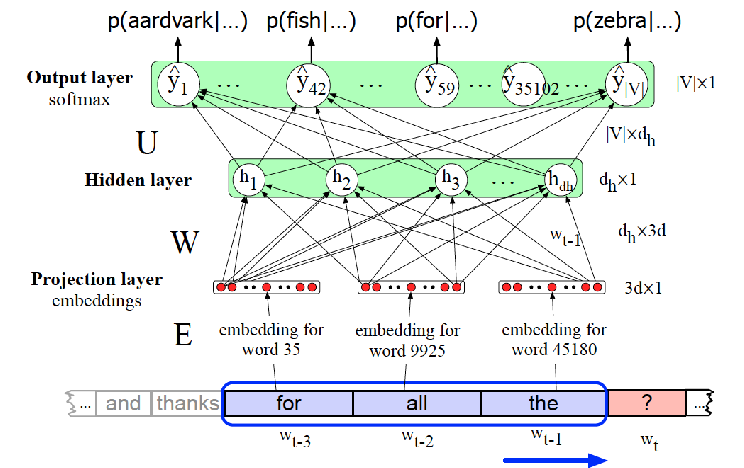

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.w = nn.Linear(
            in_features=embedding_dim,
            out_features=hidden_dim
        )

        self.k = nn.Linear(
            in_features=hidden_dim,
            out_features=hidden_dim
        )

        self.u = nn.Linear(
            in_features=hidden_dim,
            out_features=vocab_size
        )

        self.to(self.device)
        self.record_loss = []


    def forward(self, x):
        x = x.to(self.device)
        x = x.view(x.size(0), -1)
        hidden1 = nn.functional.tanh(self.w(x))
        hidden2 = nn.functional.tanh(self.k(hidden1))
        out = self.u(hidden2)
        out = nn.Dropout(p=0.1)(out)
        return nn.functional.log_softmax(out, dim=1)


    def train_with_data(self, X, Y, epochs):
        X = X.to(self.device)
        Y = Y.to(self.device)

        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        loss_fn = torch.nn.NLLLoss()

        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self(X)
            loss = loss_fn(output, Y)
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
            self.record_loss.append([epoch + 1, loss.item()])


    def train_model(self, dataset, batch_size, epochs):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = optim.Adam(self.parameters(), lr=0.01)
        loss_fn = nn.NLLLoss()

        for epoch in range(epochs):
            total_loss = 0
            for context_batch, target_batch in loader:
                context_batch = context_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                optimizer.zero_grad()
                output = self(context_batch)
                loss = loss_fn(output, target_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [ ]:
vocab_size = len(word_to_ix)
context, _ = dataset[0]
embedding_dim = context.shape[1]
hidden_dim = 300

print(f"Context size: {context_size}")
print(f"Vocab size: {vocab_size}")
print(f"Embedding dim: {embedding_dim} = {context_size} * {vocab_size}")
print(f"Tokens: {len(tokens)}")
print(f"tokens >= context_size? {len(tokens) >= context_size + 1}")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

target_idx = [v["idx"] for v in word_to_ix.values()]
print("Mínimo índice no vocabulário:", min(target_idx))
print("Máximo índice no vocabulário:", max(target_idx))

Context size: 10
Vocab size: 65
Embedding dim: 650 = 10 * 65
Tokens: 90
tokens >= context_size? True
X shape: torch.Size([80, 650])
Y shape: torch.Size([80])
Mínimo índice no vocabulário: 0
Máximo índice no vocabulário: 64


In [ ]:
model = FeedForward(
    vocab_size=len(word_to_ix),
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim
)

"""
model.train_model(
    dataset=dataset,
    batch_size=16,
    epochs=100
)
"""

model.train_with_data(X=X, Y=Y, epochs=100)

Epoch 1/100, Loss: 4.1700
Epoch 2/100, Loss: 3.5351
Epoch 3/100, Loss: 2.4054
Epoch 4/100, Loss: 1.1740
Epoch 5/100, Loss: 0.7784
Epoch 6/100, Loss: 0.4299
Epoch 7/100, Loss: 0.7645
Epoch 8/100, Loss: 0.4157
Epoch 9/100, Loss: 1.0149
Epoch 10/100, Loss: 0.7913
Epoch 11/100, Loss: 0.2718
Epoch 12/100, Loss: 0.5937
Epoch 13/100, Loss: 0.3670
Epoch 14/100, Loss: 0.5600
Epoch 15/100, Loss: 0.4321
Epoch 16/100, Loss: 0.2733
Epoch 17/100, Loss: 0.5094
Epoch 18/100, Loss: 0.2415
Epoch 19/100, Loss: 0.4268
Epoch 20/100, Loss: 0.5935
Epoch 21/100, Loss: 0.5281
Epoch 22/100, Loss: 0.5202
Epoch 23/100, Loss: 0.3698
Epoch 24/100, Loss: 0.5716
Epoch 25/100, Loss: 0.4830
Epoch 26/100, Loss: 0.6678
Epoch 27/100, Loss: 0.2933
Epoch 28/100, Loss: 0.4478
Epoch 29/100, Loss: 0.6113
Epoch 30/100, Loss: 0.3614
Epoch 31/100, Loss: 0.6449
Epoch 32/100, Loss: 0.3011
Epoch 33/100, Loss: 0.4746
Epoch 34/100, Loss: 0.2679
Epoch 35/100, Loss: 0.2512
Epoch 36/100, Loss: 0.2498
Epoch 37/100, Loss: 0.1955
Epoch 38/1

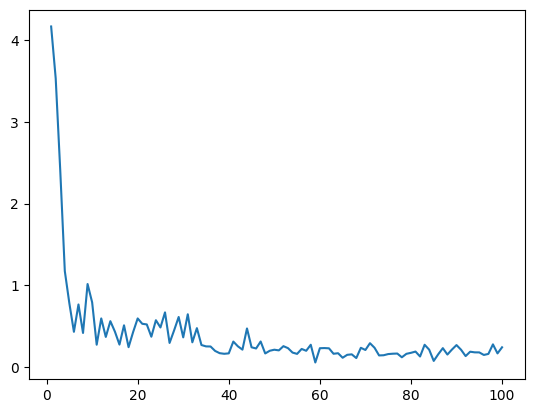

In [ ]:
import matplotlib.pyplot as plt
X = []
Y = []

for x, y in model.record_loss:
    X.append(x)
    Y.append(y)

plt.plot(X, Y)
plt.show()

In [ ]:
import time

def prever(prompt, context_size, limit=100):
    print(f"Prompt: {prompt}")
    prompt_words = prompt.split(" ")

    if len(prompt_words) < context_size:
        n_fill = context_size - len(prompt_words)
        prompt_words = ["<sos>"] * n_fill + prompt_words

    model.eval()

    print("\nGeração:", end=" ")
    for w in prompt.split(" "):
        print(w, end=" ", flush=True)

    count = 0

    while count <= limit:
        embs = []
        for word in prompt_words:
            emb = word_to_ix[word]["emb"]
            if not isinstance(emb, torch.Tensor):
                emb = torch.tensor(emb, dtype=torch.float32)
            embs.append(emb)

        concat = torch.cat(embs).view(1, -1)

        with torch.no_grad():
            output_log_probs = model.forward(concat)

        predicted_id = torch.argmax(output_log_probs, dim=1).item()
        ix_to_word = {v["idx"]: k for k, v in word_to_ix.items()}
        predicted_word = ix_to_word.get(predicted_id, "<unk>")

        if predicted_word == "<eos>":
            break

        if predicted_word != "<sos>":
            print(predicted_word, end=" ", flush=True)

        prompt_words = prompt_words[1:] + [predicted_word]
        time.sleep(0.02)
        count += 1

In [ ]:
prompt = "o projeto agents4good"

prever(
    prompt=prompt,
    context_size=context_size
)

Prompt: o projeto agents4good

Geração: o projeto agents4good realizou uma preparação cuidadosa para garantir que o evento resultasse em soluções sobre foram promovidas três oficinas e um seminário sobre tecnologias relacionadas ao evento abertos não integrantes ao alunado da uasc ufcg mas também ao público externo à ufcg para disso integrantes do projeto previamente capacitados nessas tecnologias foram distribuídos entre as equipes e do hackathon as equipes entre o apoio de mentores que detinham conhecimento sobre o domínio do problema seus ufcg preparação e dados 